###### 🔹 Object Detection

### Task 2: Apply and Analyze Object Detection Models

**Goal:** Compare a **two-stage** detector and a **single-stage** detector.

**Recommended Models:**

- Two-stage: [Faster R-CNN (TorchVision)](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)
- Single-stage: YOLO v`x` (`x` = version of your choice)

**Dataset Options:**

- [COCO 2017 (Mini subset)](https://www.kaggle.com/datasets/ultralytics/coco128) — 128 annotated images
- [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)

**Instructions:**

1. Run both detectors on the same dataset.
2. Measure:
   - Detection accuracy (mAP or precision-recall curves)
   - Inference speed (FPS)
   - Model size and memory usage
3. Visualize 5–10 images with predicted bounding boxes.
4. Optionally, test reduced input resolutions or lightweight model variants.

**Deliverables:**

- Notebook with detection and evaluation pipeline
- Quantitative comparison table
- Example detection results
- Short discussion on performance trade-offs

---

In [1]:
!pip install -U ultralytics
!pip install torchmetrics[detection]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import shutil
import time

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset, Dataset
from torchmetrics.detection import MeanAveragePrecision

import torchvision
import torchvision.transforms as T
import torchvision.utils
from torchvision import datasets, transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou

from ultralytics import YOLO

# Data split   
Coco128 2017 subest - divided into train, test and val dataset

In [3]:
# The dataset was downloaded manually
DATA_DIR = "coco128"
IMG_DIR = os.path.join(DATA_DIR, "images/train2017")
LBL_DIR = os.path.join(DATA_DIR, "labels/train2017")
CLASS_COUNT = 80

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATA_DIR, f"images/{split}"), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, f"labels/{split}"), exist_ok=True)

label_files = []
valid_indices = [] # Only indices that have a complete pair (image + label)
all_label_files = [f for f in os.listdir(LBL_DIR) if f.endswith(".txt")]

for i, lbl_file in enumerate(all_label_files):

    img_file = lbl_file.replace(".txt", ".jpg")
    if os.path.exists(os.path.join(IMG_DIR, img_file)) and os.path.exists(os.path.join(LBL_DIR, lbl_file)):
        label_files.append(lbl_file)
        valid_indices.append(i)
    else:
        print(f"Skipping incomplete pair: {lbl_file}")
        
print(f"\nFound {len(label_files)} complete pairs (image + label).")

Y = np.zeros((len(label_files), CLASS_COUNT), dtype=int)
for i, lbl_file in enumerate(label_files):
    path = os.path.join(LBL_DIR, lbl_file)
    if os.path.getsize(path) == 0:
        continue
    data = np.loadtxt(path, ndmin=2, dtype=float)
    for row in data:
        cls_id = int(row[0])
        if 0 <= cls_id < CLASS_COUNT:
            Y[i, cls_id] += 1

label_files_array = np.array(label_files)

# Stratified split
msss_train_temp = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_indices, temp_indices = next(msss_train_temp.split(label_files_array, Y))
train_files = label_files_array[train_indices]
temp_files = label_files_array[temp_indices]
Y_temp = Y[temp_indices] 

msss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_indices, test_indices = next(msss_val_test.split(temp_files, Y_temp))
val_files = temp_files[val_indices]
test_files = temp_files[test_indices]

print(f"\nData split:")
print(f"Total images: {len(label_files_array)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

def copy_pairs(file_list, split):
    for lbl_file in file_list:
        img_file = lbl_file.replace(".txt", ".jpg")
        
        shutil.copy(os.path.join(IMG_DIR, img_file), os.path.join(DATA_DIR, f"images/{split}", img_file))
        shutil.copy(os.path.join(LBL_DIR, lbl_file), os.path.join(DATA_DIR, f"labels/{split}", lbl_file))
    print(f"Copied {len(file_list)} pairs to the '{split}' folder")

copy_pairs(train_files, "train")
copy_pairs(val_files, "val")
copy_pairs(test_files, "test")

Skipping incomplete pair: 000000000656.txt
Skipping incomplete pair: 000000000659.txt

Found 126 complete pairs (image + label).

Data split:
Total images: 126
Training images: 82
Validation images: 23
Test images: 21
Copied 82 pairs to the 'train' folder
Copied 23 pairs to the 'val' folder
Copied 21 pairs to the 'test' folder


In [4]:
class_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [5]:
# Metrics that need to be collected
frcnn_map_95 = 0.0    
frcnn_map_50 = 0.0    
frcnn_fps = 0.0       
frcnn_vram_gb = 0.0  
frcnn_size_mb = 0.0   

yolo_map_95 = 0.0    
yolo_map_50 = 0.0    
yolo_fps = 0.0        
yolo_vram_gb = 0.0    
yolo_size_mb = 0.0  

# Faster R-CNN

### Load model

In [6]:
# Load model - pretrained
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
FRCNN = fasterrcnn_resnet50_fpn(weights=weights)
num_classes = 81 # +1 for background
in_features = FRCNN.roi_heads.box_predictor.cls_score.in_features

# New head of the model with the right num_classes
FRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Adjust dataset for two-stage detector

In [7]:
# Dataset preparation

# Function that changes data from YOLO format to Pascal VOC format
def yolo_to_pascal_voc(x_center, y_center, width, height, img_w, img_h):
    x_center_px = x_center * img_w
    y_center_px = y_center * img_h
    width_px = width * img_w
    height_px = height * img_h

    x_min = x_center_px - (width_px / 2)
    y_min = y_center_px - (height_px / 2)
    x_max = x_center_px + (width_px / 2)
    y_max = y_center_px + (height_px / 2)

    return [x_min, y_min, x_max, y_max]
    
class CocoFasterRCNNDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)

        img_w, img_h = img.size
        boxes, labels = [], []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  

                    class_label, x, y, w, h = map(float, parts)
                    box = yolo_to_pascal_voc(x, y, w, h, img_w, img_h)

                    if box[2] > box[0] and box[3] > box[1]:
                        boxes.append(box)
                        labels.append(int(class_label) + 1)  # +1 for background


        if len(boxes) == 0:
            new_idx = (idx + 1) % len(self.image_files)
            return self.__getitem__(new_idx)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

### Load dataset

In [8]:
# Load dataset
DATA_DIR = "coco128"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "images/train")
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, "labels/train")
VAL_IMG_DIR = os.path.join(DATA_DIR, "images/val")
VAL_LABEL_DIR = os.path.join(DATA_DIR, "labels/val")
TEST_IMG_DIR = os.path.join(DATA_DIR, "images/test")
TEST_LABEL_DIR = os.path.join(DATA_DIR, "labels/test")

transform = T.Compose([
    T.ToTensor(),
])

train_dataset = CocoFasterRCNNDataset(
    img_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LABEL_DIR,
    transforms=transform
)
val_dataset = CocoFasterRCNNDataset(
    img_dir=VAL_IMG_DIR,
    label_dir=VAL_LABEL_DIR,
    transforms=transform
)
test_dataset = CocoFasterRCNNDataset(
    img_dir=TEST_IMG_DIR,
    label_dir=TEST_LABEL_DIR,
    transforms=transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

### Train model + calculate memory usage

In [9]:
# Training loop

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
FRCNN.to(device)

params = [p for p in FRCNN.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 30
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats(0)

for epoch in range(num_epochs):
    
    FRCNN.train()  
    train_loss = 0.0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = FRCNN(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    lr_scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    
    print(f"--- Epoch: {epoch + 1}---")
    print(f"Training Loss: {avg_train_loss:.4f}")

    FRCNN.eval() 
    
    metric = MeanAveragePrecision(box_format='xyxy').to(device)

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets_gpu = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = FRCNN(images) 

            preds = [{ 
                "boxes": out["boxes"],
                "scores": out["scores"],
                "labels": out["labels"]
            } for out in outputs]
            
            tgts = [{ 
                "boxes": tgt["boxes"],      
                "labels": tgt["labels"]
            } for tgt in targets_gpu]
            
            metric.update(preds, tgts)

    map_result = metric.compute()
    
    print(f"Validation mAP: {map_result['map'].item():.4f}")
    print(f"Validation mAP_50: {map_result['map_50'].item():.4f}")
    print("-" * 30)
if torch.cuda.is_available():
    frcnn_vram_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
    print(f"Peak VRAM memory usage during training: {frcnn_vram_gb:.2f} GB")

--- Epoch: 1---
Training Loss: 1.9385
Validation mAP: 0.0039
Validation mAP_50: 0.0118
------------------------------
--- Epoch: 2---
Training Loss: 1.2742
Validation mAP: 0.0083
Validation mAP_50: 0.0176
------------------------------
--- Epoch: 3---
Training Loss: 1.1441
Validation mAP: 0.0112
Validation mAP_50: 0.0191
------------------------------
--- Epoch: 4---
Training Loss: 1.1104
Validation mAP: 0.0127
Validation mAP_50: 0.0192
------------------------------
--- Epoch: 5---
Training Loss: 1.0575
Validation mAP: 0.0125
Validation mAP_50: 0.0194
------------------------------
--- Epoch: 6---
Training Loss: 1.0562
Validation mAP: 0.0123
Validation mAP_50: 0.0194
------------------------------
--- Epoch: 7---
Training Loss: 1.0489
Validation mAP: 0.0125
Validation mAP_50: 0.0194
------------------------------
--- Epoch: 8---
Training Loss: 1.0663
Validation mAP: 0.0124
Validation mAP_50: 0.0194
------------------------------
--- Epoch: 9---
Training Loss: 1.0447
Validation mAP: 0.

The loss is unstable, as it sometimes increases instead of dropping. Also the MAP metrics on validation dataset achieve very low scores, which indicates that the model is not learning. This might be caused due to very limited and unbalanced dataset.

### Save model and calculate its size

In [10]:
torch.save(FRCNN.state_dict(), "fasterrcnn.pth")
frcnn_size_mb = os.path.getsize("fasterrcnn.pth") / (1024 * 1024)
print(f"Model size: {frcnn_size_mb:.2f} MB")

total_params_frcnn = sum(p.numel() for p in FRCNN.parameters())
frcnn_params_M = total_params_frcnn / 1_000_000 

total_trainable_frcnn = sum(p.numel() for p in FRCNN.parameters() if p.requires_grad)
frcnn_trainable_M = total_trainable_frcnn / 1_000_000 

print("-" * 35)
print(f"Faster R-CNN total parameters: {frcnn_params_M:.2f} M")
print("-" * 35)
print(f"Faster R-CNN trainable parameters: {frcnn_trainable_M:.2f} M")

Model size: 159.60 MB
-----------------------------------
Faster R-CNN total parameters: 41.70 M
-----------------------------------
Faster R-CNN trainable parameters: 41.48 M


### Evaluate model on test dataset - mAP metrics

In [11]:
FRCNN.eval()

for images, targets in test_loader:
    images = [img.to(device) for img in images]
    
    targets_gpu = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = FRCNN(images)
    
    preds = [{ 
        "boxes": out["boxes"],
        "scores": out["scores"],
        "labels": out["labels"]
    } for out in outputs]
    
    tgts = [{ 
        "boxes": tgt["boxes"],
        "labels": tgt["labels"]
    } for tgt in targets_gpu]
    
    metric.update(preds, tgts)

map_result = metric.compute()
print("--- Ewaluation on test dataset (mAP) ---")

for key, value in map_result.items():
    
    if isinstance(value, torch.Tensor):
        
        if value.numel() == 1:
            print(f"{key}: {value.item():.4f}")
        else:
            print(f"{key}: {value}")

frcnn_map_95 = map_result['map'].item()
frcnn_map_50 = map_result['map_50'].item()

--- Ewaluation on test dataset (mAP) ---
map: 0.0121
map_50: 0.0211
map_75: 0.0149
map_small: 0.0086
map_medium: 0.0292
map_large: 0.0215
mar_1: 0.0080
mar_10: 0.0134
mar_100: 0.0136
mar_small: 0.0131
mar_medium: 0.0315
mar_large: 0.0229
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 15, 16, 17, 21, 23, 24,
        25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 68, 69, 70, 72, 73, 74, 75, 76, 78, 80], dtype=torch.int32)


Again, the map metrics archieved very low scores.

### Measure FPS

In [12]:
FRCNN.to(device)
FRCNN.eval()  

total_images = 0
total_time = 0
warmup_batches = 2

print("Beginning FPS measurement")

with torch.no_grad():

    for i, (images, _) in enumerate(test_loader):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        if i >= warmup_batches:
            start_time = time.time()

        outputs = FRCNN(images)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        if i >= warmup_batches:
            end_time = time.time()
            total_time += (end_time - start_time)
            total_images += len(images) 

if total_images == 0:
    print("The dataset is too small")
else:
    frcnn_fps = total_images / total_time
    print("-" * 30)
    print(f"Processed images: {total_images}")
    print(f"Total measurement time: {total_time:.2f} s")
    print(f"Frames per second: {frcnn_fps:.2f}")

Beginning FPS measurement
------------------------------
Processed images: 13
Total measurement time: 0.84 s
Frames per second: 15.52


# YOLOv8

### Creating yaml file for training and validation

In [13]:
# Creating yaml file for YOLO training and validation
DATA_DIR = "coco128"
YAML_PATH = os.path.join(DATA_DIR, "coco128.yaml")

yaml_content = f"""
path: {os.path.abspath(DATA_DIR)}
train: images/train  
val: images/val
test: images/test

nc: 80 
names: [
  'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 
  'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 
  'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 
  'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
  'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
  'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
  'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 
  'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 
  'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 
  'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush' 
]
"""

try:
    with open(YAML_PATH, "w") as f:
        f.write(yaml_content)
except Exception as e:
    print(f"Error: {e}")

In [ ]:
yolo = YOLO("yolov8n.pt")

### Model training and calculating memory usage

In [15]:
import warnings
warnings.filterwarnings("ignore")

torch.cuda.reset_peak_memory_stats(0)
DATA_YAML_PATH = "coco128/coco128.yaml"
results = yolo.train(
    data=DATA_YAML_PATH,
    epochs=30,
    imgsz=640
)

yolo_vram_gb = torch.cuda.max_memory_allocated(0) / (1024**3) 
print("-" * 30)
print(f"YOLOv8 peak VRAM usage: {yolo_vram_gb:.2f} GB")

Ultralytics 8.3.223 🚀 Python-3.12.6 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128/coco128.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

# Evaluation on validation dataset - mAP metrics

In [16]:
yolo = YOLO('runs/detect/train/weights/best.pt')
#Val results will be saved into val folder
results = yolo.val(data='coco128/coco128.yaml', split='val', imgsz=640)

Ultralytics 8.3.223 🚀 Python-3.12.6 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1300.4±528.0 MB/s, size: 53.7 KB)
val: Scanning /home/jupyter-st126128/Assignment_2/coco128/labels/val.cache... 23 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 23/23 32.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.6it/s 0.8s0.9s
                   all         23        148      0.641      0.545      0.663      0.467
                person          9         19      0.959      0.895      0.921      0.795
                   car          2          2      0.319        0.5      0.497      0.154
                   bus          1          1      0.583          1      0.995      0.995
                 truck          1          1      0.723          1      0.995      0.895
        

### Model size

In [20]:
yolo_model_path = "runs/detect/train/weights/best.pt" 
file_size_bytes = os.path.getsize(yolo_model_path)
yolo_size_mb = file_size_bytes / (1024 * 1024) 
print(f"YOLOv8 size: {yolo_size_mb:.2f} MB")

total_params_yolo = sum(p.numel() for p in yolo.model.parameters())
yolo_params_M = total_params_yolo / 1_000_000 
print("-" * 35)
print(f"YOLOv8 total parameters: {yolo_params_M:.2f} M")

YOLOv8 size: 6.24 MB
-----------------------------------
YOLOv8 total parameters: 3.15 M


### Evaluation on test dataset + FPS

In [21]:
print("Evaluation on test dataset (mAP & FPS)")

#Test results will be saved into val2 folder
results = yolo.val(
    data='coco128/coco128.yaml',
    split='test',  
    imgsz=640    
)

yolo_map_95 = results.box.map  
yolo_map_50 = results.box.map50          
   
print(f"Test mAP_50-95: {yolo_map_95:.4f}")
print(f"Test mAP_50: {yolo_map_50:.4f}")

print("\n--- Test Speed (FPS) ---")
total_time_ms = results.speed['preprocess'] + results.speed['inference'] + results.speed['postprocess']

yolo_fps = 1000 / total_time_ms

print(f"Total time per image: {total_time_ms:.2f} ms")
print(f"Calculated FPS: {yolo_fps:.2f}")

Evaluation on test dataset (mAP & FPS)
Ultralytics 8.3.223 🚀 Python-3.12.6 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11004MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 734.4±230.6 MB/s, size: 42.5 KB)
val: Scanning /home/jupyter-st126128/Assignment_2/coco128/labels/test.cache... 21 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 21/21 24.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.3it/s 0.9s1.0s
                   all         21        182      0.644      0.581       0.63      0.505
                person         11         45       0.74      0.778      0.821       0.57
               bicycle          1          3          1          0      0.365      0.365
                   car          2         19      0.371     0.0526       0.13     0.0762
            motorcycle          1          1      0.411          1      0.995      0.895
              airplane          2          3     

# Example detection results for both models

Ground Truth: Green, Prediction: Red, Conf > 0.5


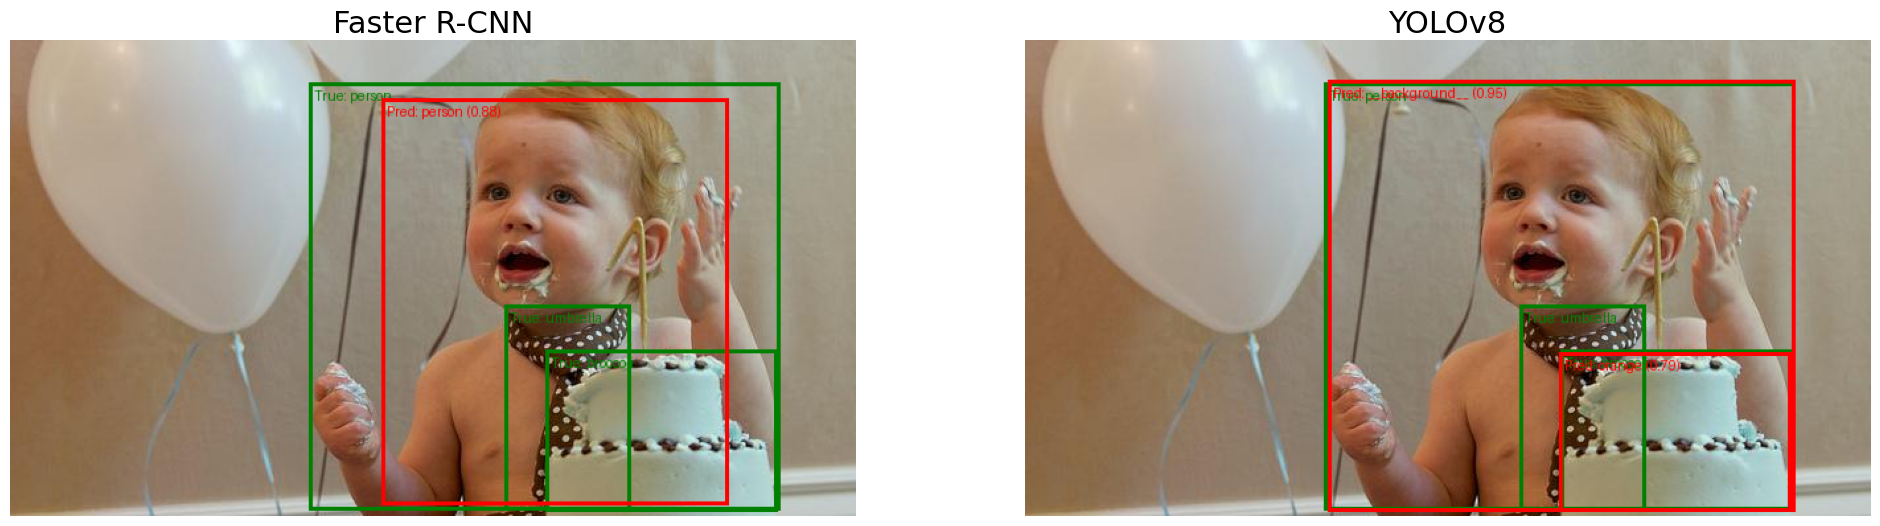

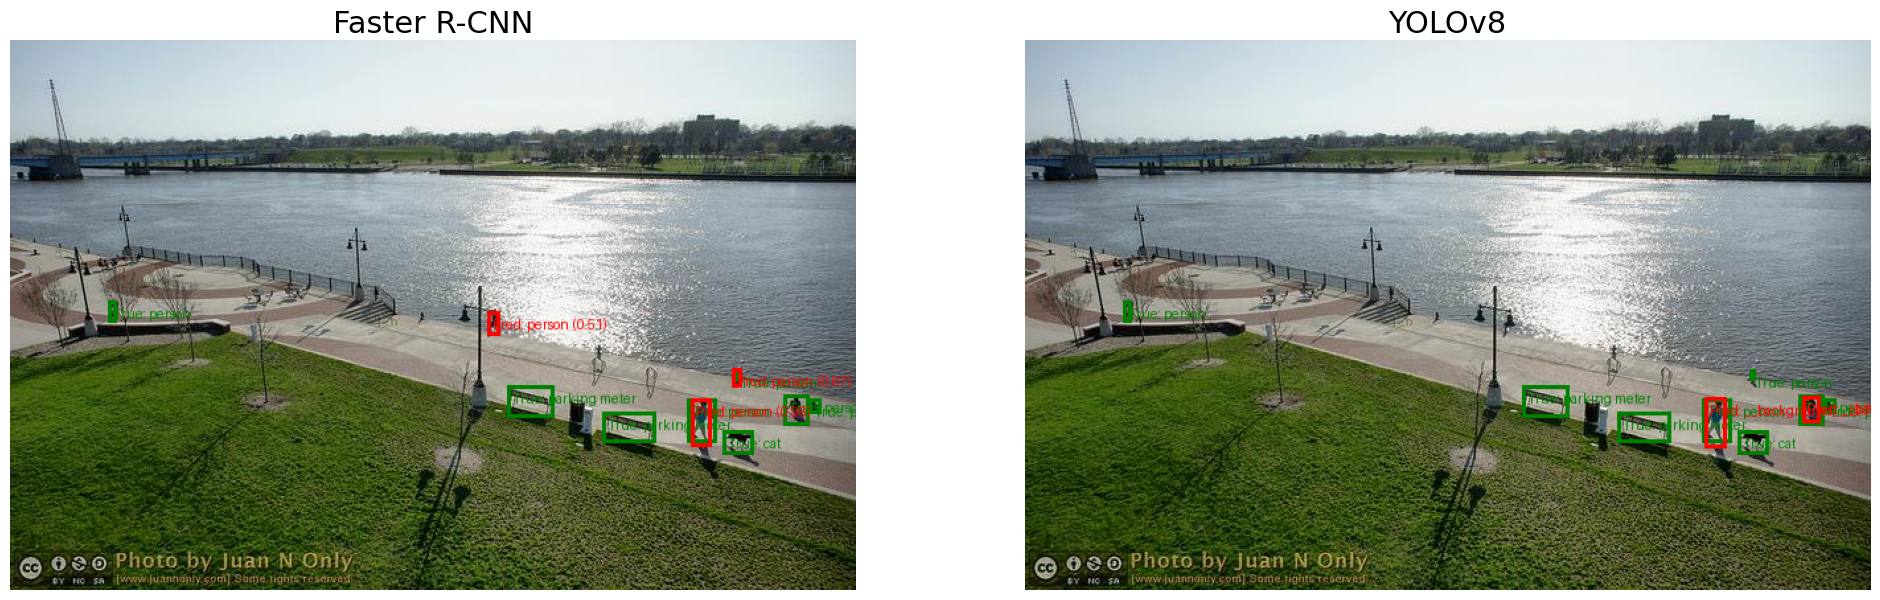

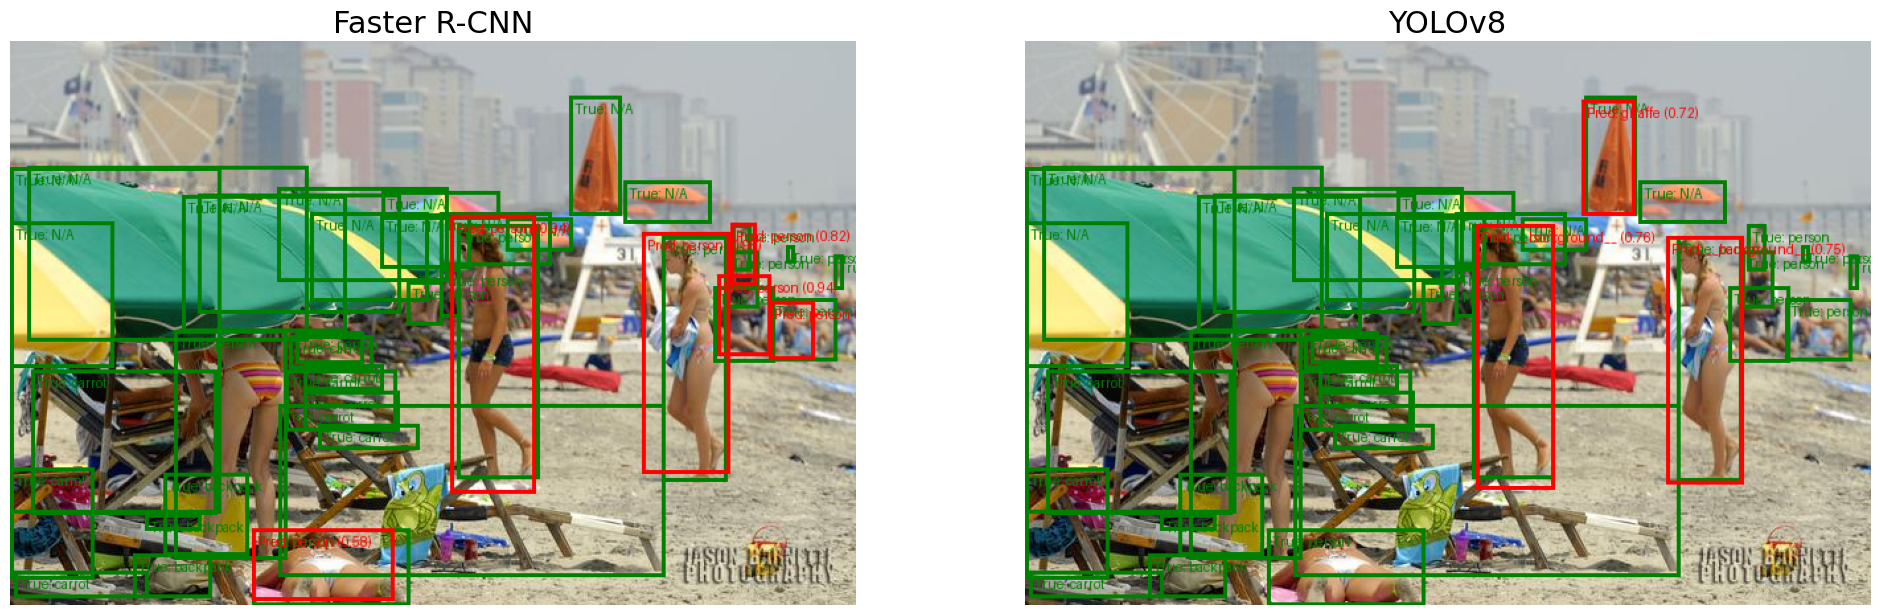

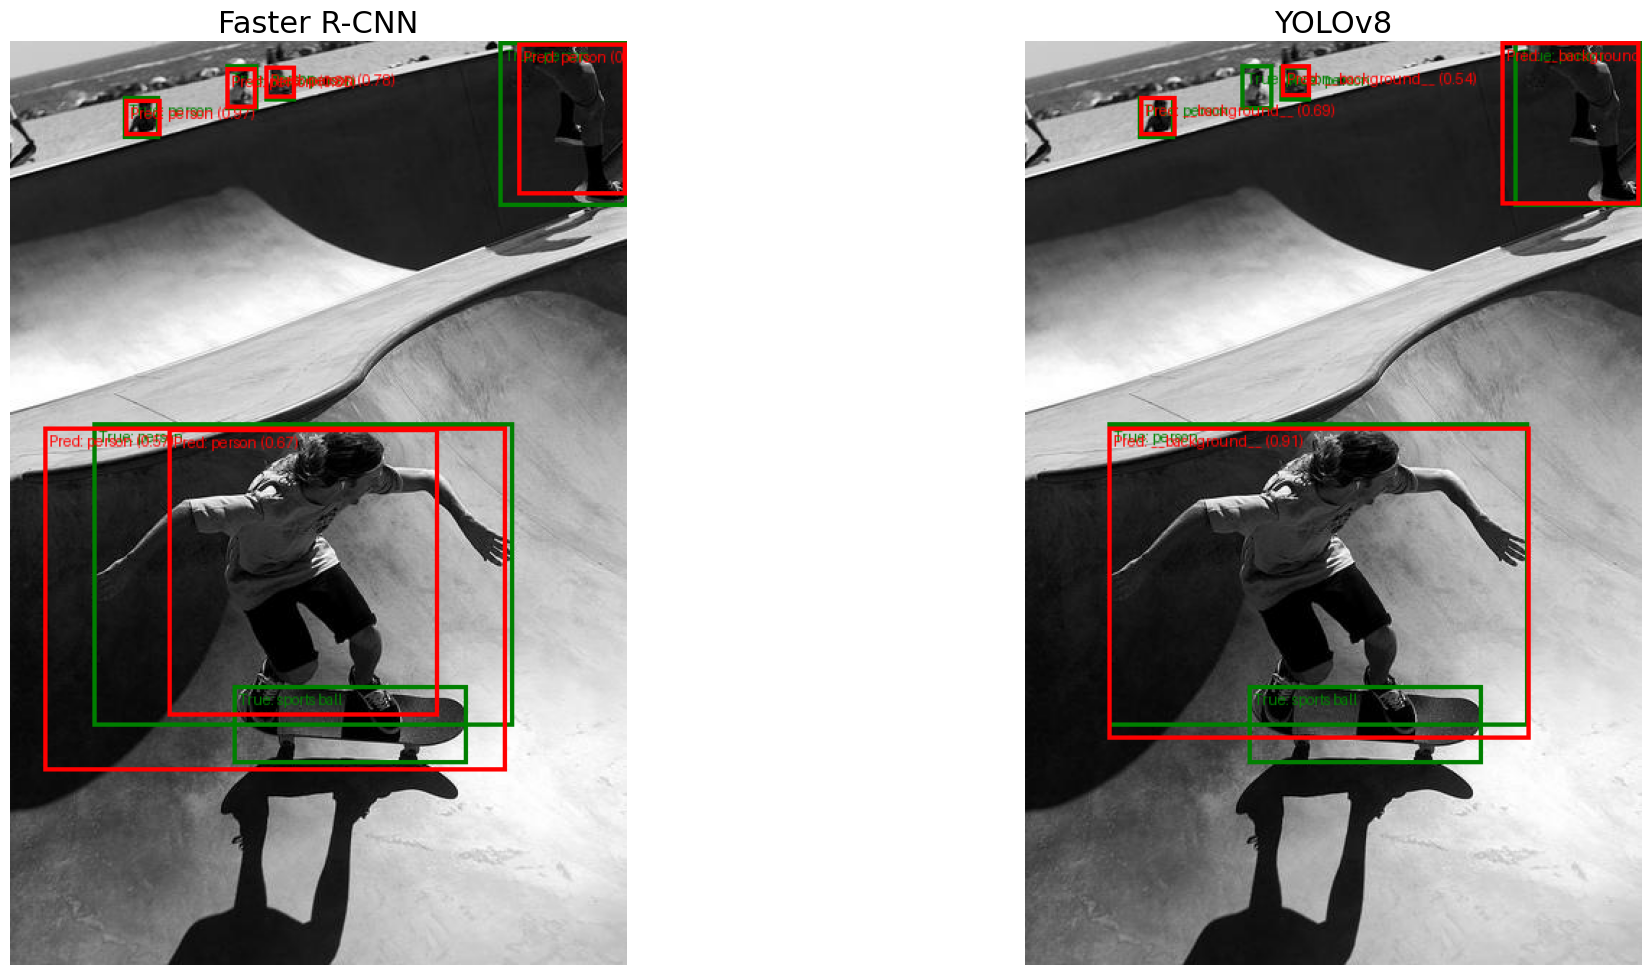

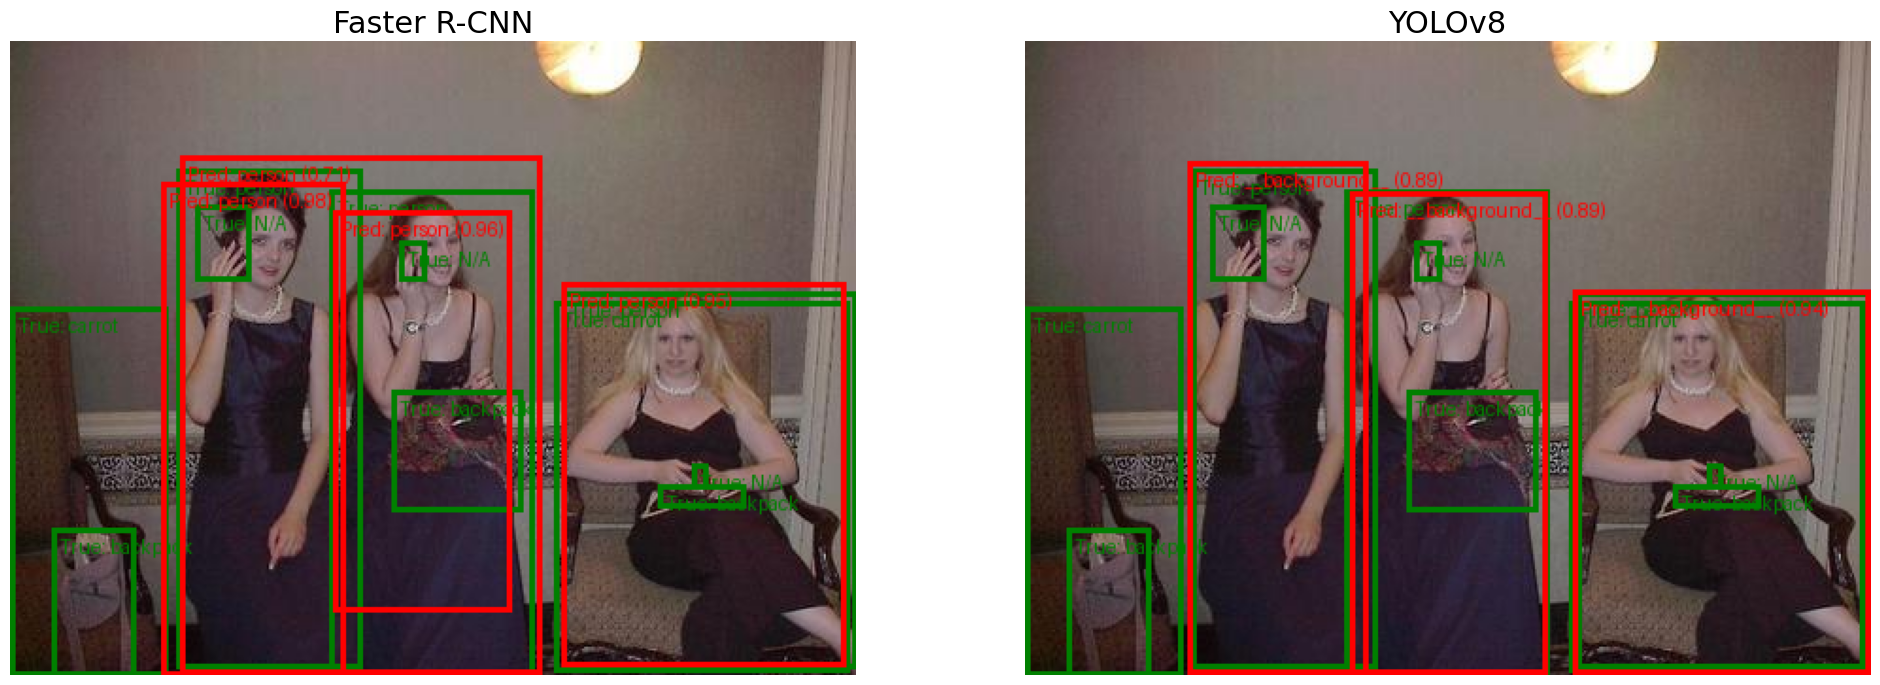

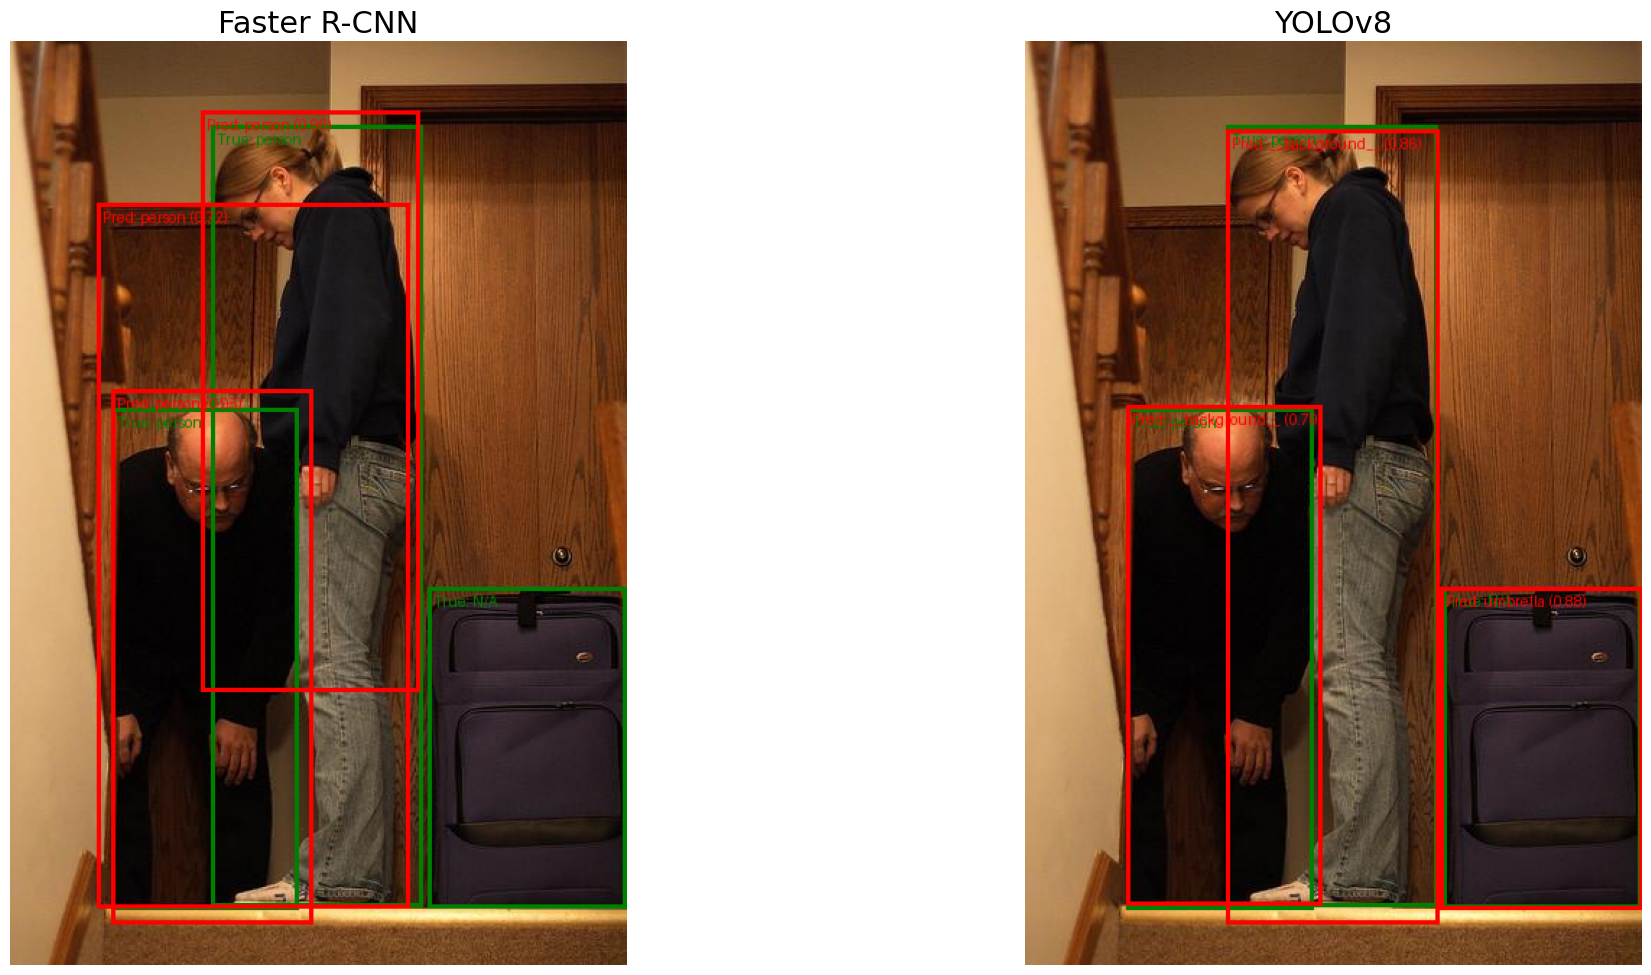

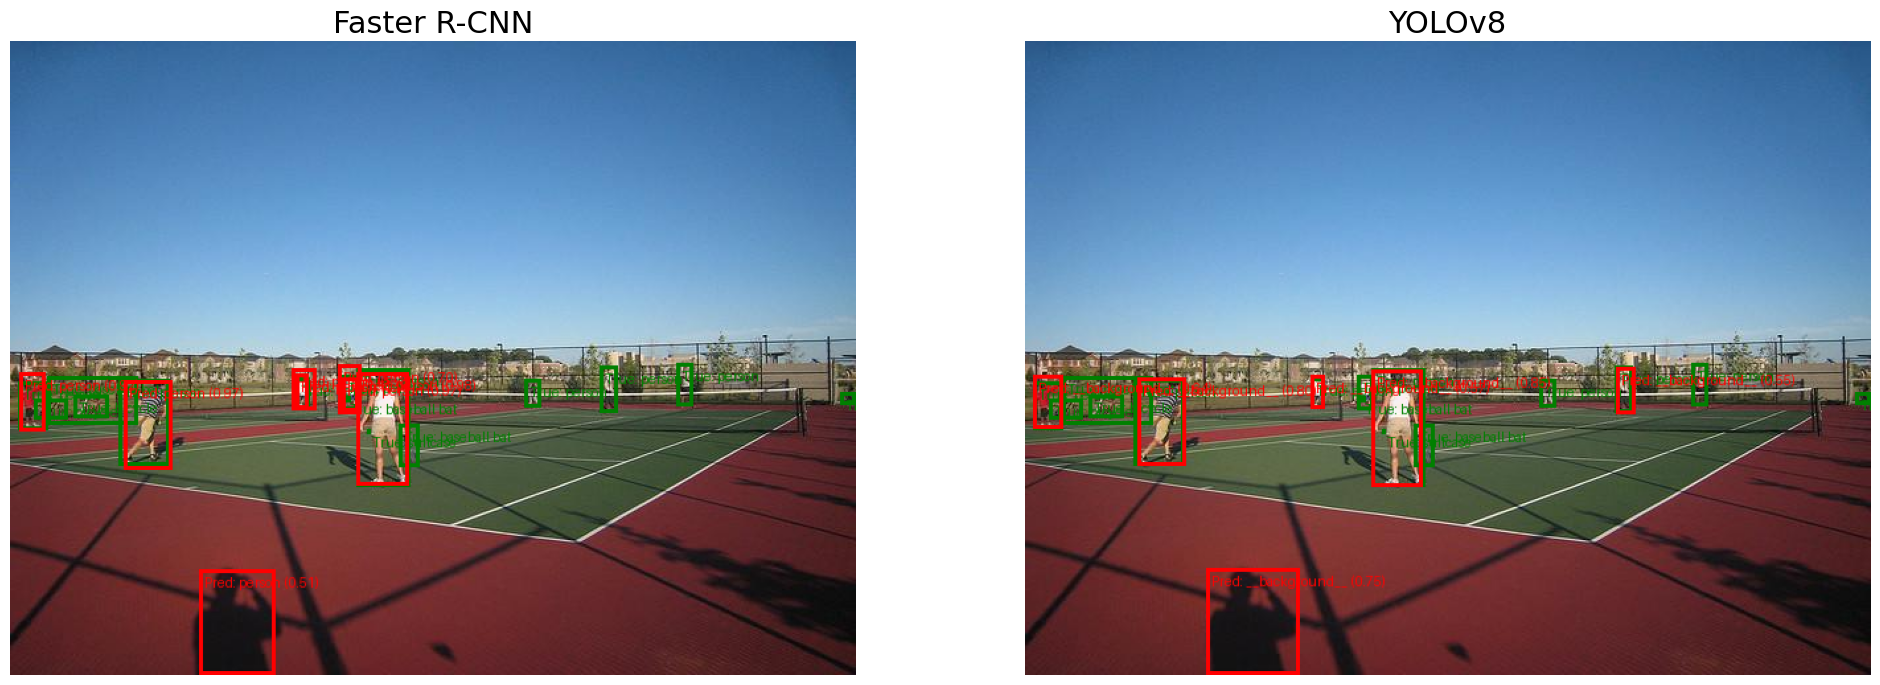

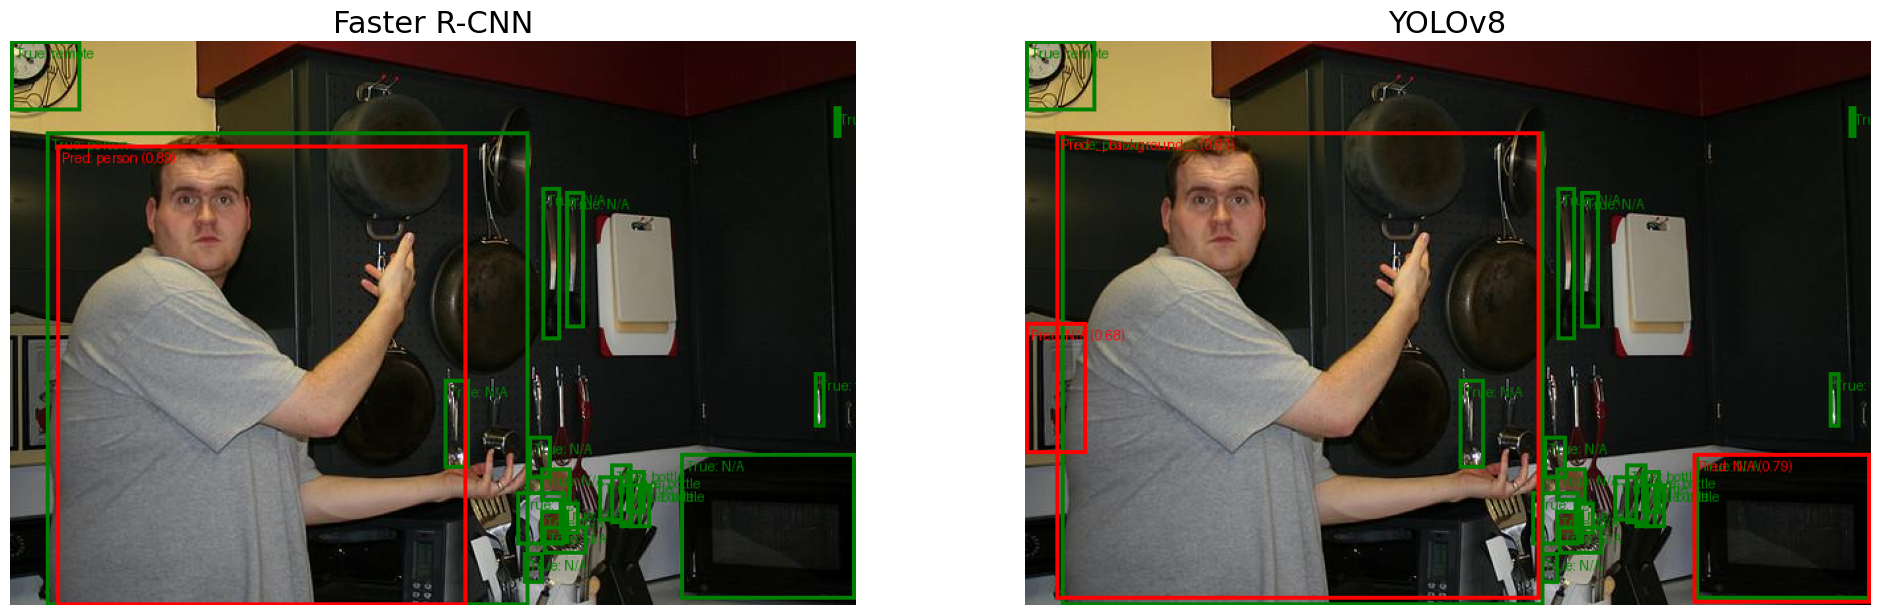

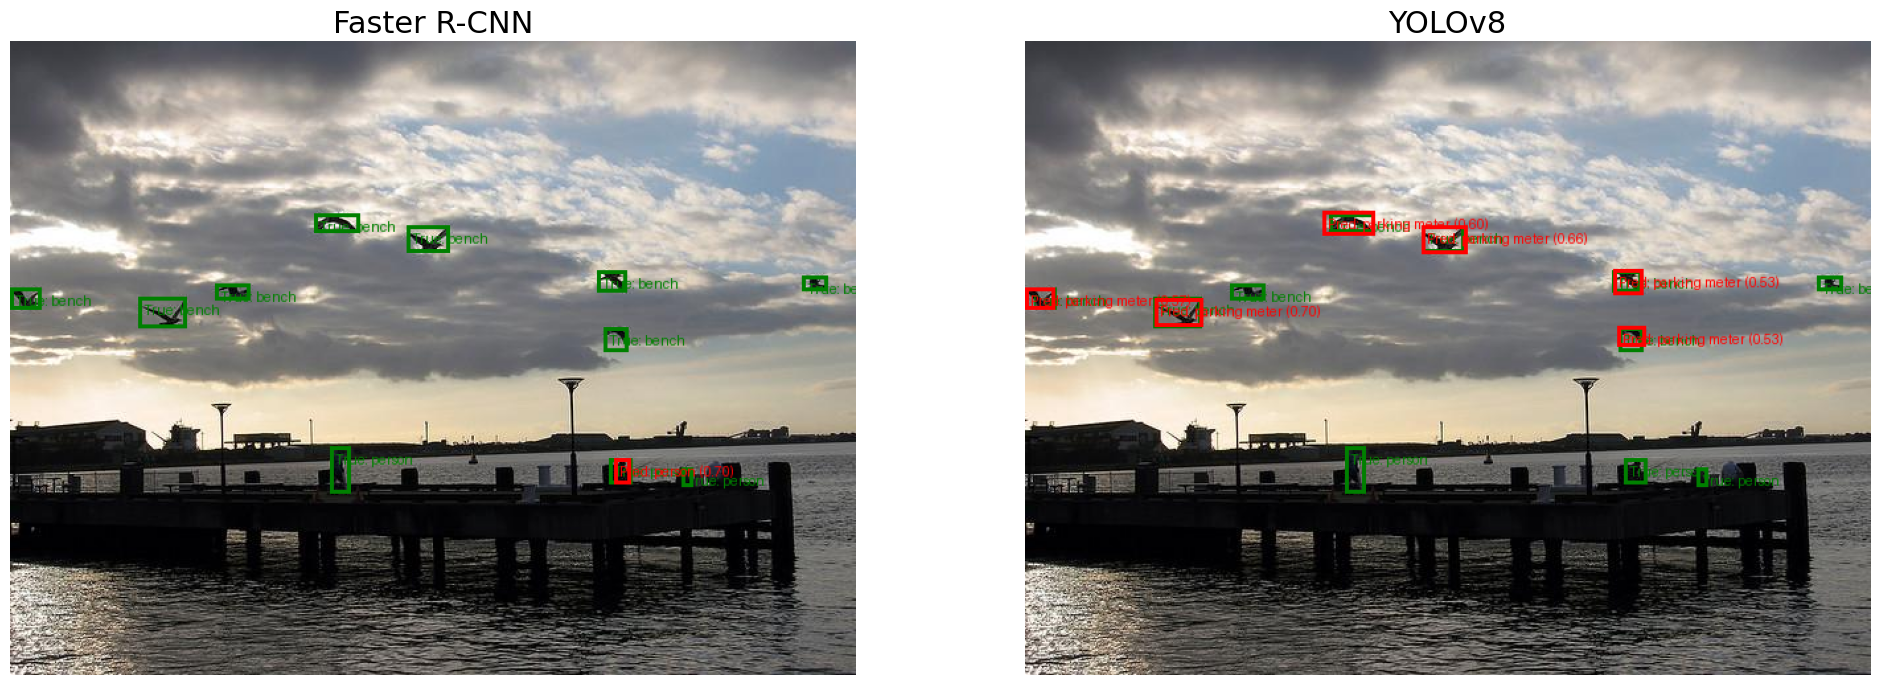

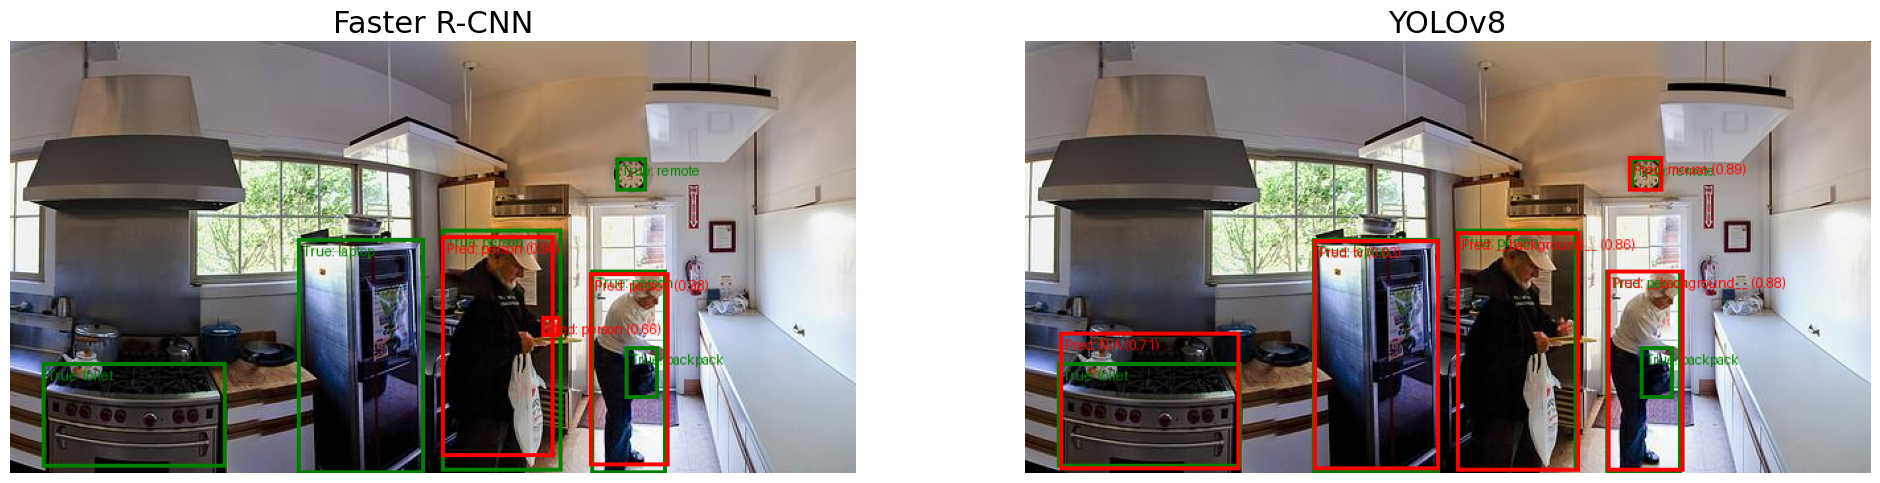

In [24]:
%matplotlib inline
score_threshold = 0.5
num_comparisons = 10 
test_labels_path = 'coco128/labels/test'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

FRCNN.eval()
yolo.eval()

def draw_results_array(image_tensor, model_preds, ground_truth_boxes, ground_truth_labels, score_threshold, class_names):
    
    img_int = (image_tensor * 255).to(torch.uint8)
    
    pred_mask = model_preds['scores'] > score_threshold
    pred_boxes = model_preds['boxes'][pred_mask].cpu()
    pred_labels_indices = model_preds['labels'][pred_mask].cpu().tolist()
    pred_scores = model_preds['scores'][pred_mask].cpu().tolist()
    pred_labels_text = [
        f"Pred: {class_names[int(idx)]} ({score:.2f})" 
        for idx, score in zip(pred_labels_indices, pred_scores)
    ]
    
    gt_labels_text = [f"True: {class_names[int(idx)]}" for idx in ground_truth_labels]

    all_boxes = torch.cat([ground_truth_boxes, pred_boxes])
    all_labels = gt_labels_text + pred_labels_text
    all_colors = ['green'] * len(gt_labels_text) + ['red'] * len(pred_labels_text)

    if len(all_boxes) == 0:
        return img_int.permute(1, 2, 0).cpu().numpy()
        
    img_with_boxes = torchvision.utils.draw_bounding_boxes(
        img_int,
        boxes=all_boxes.int(),
        labels=all_labels,
        colors=all_colors,
        width=3
    )
    return img_with_boxes.permute(1, 2, 0).cpu().numpy()

images_processed = 0
print(f"Ground Truth: Green, Prediction: Red, Conf > {score_threshold}")
with torch.no_grad():
    for images, targets in test_loader: 
        if images_processed >= num_comparisons:
            break
            
        images_gpu = [img.to(device) for img in images]
        frcnn_batch_outputs = FRCNN(images_gpu)

        for i in range(len(images)):
            if images_processed >= num_comparisons:
                break
                
            img_tensor = images[i].cpu()
            frcnn_preds_raw = frcnn_batch_outputs[i]
            
            if not (frcnn_preds_raw['scores'].cpu() > score_threshold).any():
                continue 

            frcnn_preds_dict = {k: v.cpu() for k, v in frcnn_preds_raw.items()}
            
            image_np = img_tensor.permute(1, 2, 0).numpy()
            image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
            yolo_outputs = yolo.predict(source=image_pil, verbose=False)
            
            yolo_preds_dict = {
                'boxes': torch.tensor(yolo_outputs[0].boxes.xyxy.cpu().numpy()),
                'labels': yolo_outputs[0].boxes.cls.cpu(),
                'scores': yolo_outputs[0].boxes.conf.cpu()
            }
            
            gt_boxes = targets[i]['boxes'].cpu()
            gt_labels = targets[i]['labels'].cpu().tolist()

            frcnn_img_array = draw_results_array(
                img_tensor, frcnn_preds_dict, gt_boxes, gt_labels, score_threshold, class_names
            )
            
            yolo_img_array = draw_results_array(
                img_tensor, yolo_preds_dict, gt_boxes, gt_labels, score_threshold, class_names
            )
            
            fig, axes = plt.subplots(1, 2, figsize=(24, 12))
            
            axes[0].imshow(frcnn_img_array)
            axes[0].set_title(f"Faster R-CNN", fontsize=22)
            axes[0].axis('off')
            
            axes[1].imshow(yolo_img_array)
            axes[1].set_title(f"YOLOv8", fontsize=22)
            axes[1].axis('off')

            plt.show()
            images_processed += 1

Faster R-CNN model usually correctly predicts people, but very often misses the rest of classes. YOLOv8 is more capable of detetcing other object, especially big (such as fridge or suitcase), but it sometimes misses smaller object. Overall YOLOv8 detects more objects among all classes, despite that the dataset was unbalanced.

# Comparison table

In [23]:
data = {
    'Faster R-CNN': [frcnn_map_95, frcnn_map_50, frcnn_fps, frcnn_vram_gb, frcnn_params_M, frcnn_size_mb],
    'YOLOv8': [yolo_map_95, yolo_map_50, yolo_fps, yolo_vram_gb, yolo_params_M, yolo_size_mb]
}

index_labels = [
    'mAP (test @ .50-.95)',
    'mAP (test @ .50)',
    'FPS (test)',
    'Peak VRAM (GB)',        
    'Model parameters (M)',
    'Model size (MB)'
]

 
df_results = pd.DataFrame(data, index=index_labels)
pd.options.display.float_format = '{:,.3f}'.format
display(df_results)
print('mAP metrics and FPS were calculated on test dataset')
print('Peak VRAM was calculated during model training')

Faster R-CNN  YOLOv8
mAP (test @ .50-.95)         0.012   0.505
mAP (test @ .50)             0.021   0.630
FPS (test)                  15.522  35.406
Peak VRAM (GB)               7.473   2.714
Model parameters (M)        41.704   3.152
Model size (MB)            159.596   6.238

mAP metrics and FPS were calculated on test dataset
Peak VRAM was calculated during model training


The comparison table shows, that YOLOv8 not only achieved significantly better mAP and FPS results than Faster RCNN, but also used less memory during training and the trained model takes less memory space. 
* YOLOv8 achieved significantly higher scores in mAP metrics. YOLOv8 is able to detect more objects from different classes than FRCNN.
* YOLOv8 can proces more frames per second than Faster RCNN.
* Faster RCNN requires more memory during training.
* YOLO model takes very little space, which idicates that its indeed a lightweight model.
* YOLOv8 is simpler than FRCNN, because it has less model parameters, but achieves better results than FRCNN.
The results show that YOLOv8 does not present a trade-off but offers dominant performance. The architecture delivers high detection accuracy (mAP) while simultaneously reducing computational cost (VRAM usage) and increasing inference speed (FPS).